# Set Parameter
- Attention = [None, Luong]
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32
- Drop out = 0.2
- Hidden unit = 50
- Epochs = 100
- N = 100
- Data Length = 100K
- Single
- Deduplication

# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

from trainer.supervised_trainer import SupervisedTrainer
from models.encoderRNN import EncoderRNN
from models.decoderRNN import DecoderRNN
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.predictor import Predictor

import matplotlib.pyplot as plt

/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


# Log format

In [2]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

In [3]:
character_accuracy = []
sentance_accuracy = []

In [4]:
train_path = "data/palindrome_dedup/K100_single/data_train.txt"
dev_path = "data/palindrome_dedup/K100_single/data_test.txt"

src = fields.SourceField()
tgt = fields.TargetField()
max_len = 104
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
train = torchtext.data.TabularDataset(
    path=train_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
dev = torchtext.data.TabularDataset(
    path=dev_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
src.build_vocab(train)
tgt.build_vocab(train)
input_vocab = src.vocab
output_vocab = tgt.vocab

weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()
    
optimizer = "Adam"
hidden_size = 50
bidirectional = True

/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Prepare dataset

In [ ]:
print("None Att")

seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                    bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention=None, bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="palindrome_dedup_K100_single_parameter/None_att")

seq2seq, ave_loss, character_accuracy_list, sentance_accuracy_list = t.train(seq2seq, train,
                                                                             num_epochs=100, dev_data=dev,
                                                                             optimizer=optimizer,
                                                                             teacher_forcing_ratio=0.5)

character_accuracy.append(character_accuracy_list)
sentance_accuracy.append(sentance_accuracy_list)

torch.save(seq2seq.state_dict(), 'log/pth/palindrome_dedup_K100_single_parameter_no_att_model_save.pth')

/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
2019-03-20 17:58:30,956 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


None Att


2019-03-20 18:00:45,299 INFO   Finished epoch 1: Train loss: 12.5894, Dev loss: 6.9193, Accuracy(Character): 0.5161, Accuracy(Word): 0.0264
2019-03-20 18:03:01,137 INFO   Finished epoch 2: Train loss: 5.0394, Dev loss: 11.8237, Accuracy(Character): 0.5067, Accuracy(Word): 0.0047
2019-03-20 18:05:15,255 INFO   Finished epoch 3: Train loss: 5.1067, Dev loss: 10.4077, Accuracy(Character): 0.5214, Accuracy(Word): 0.1238
2019-03-20 18:07:28,673 INFO   Finished epoch 4: Train loss: 5.1833, Dev loss: 10.8142, Accuracy(Character): 0.5104, Accuracy(Word): 0.0294
2019-03-20 18:09:43,918 INFO   Finished epoch 5: Train loss: 4.6355, Dev loss: 18.1990, Accuracy(Character): 0.4916, Accuracy(Word): 0.0001
2019-03-20 18:11:59,321 INFO   Finished epoch 6: Train loss: 4.3152, Dev loss: 21.0638, Accuracy(Character): 0.4828, Accuracy(Word): 0.0001
2019-03-20 18:14:13,331 INFO   Finished epoch 7: Train loss: 4.1764, Dev loss: 31.3807, Accuracy(Character): 0.4469, Accuracy(Word): 0.0000
2019-03-20 18:16:27,

2019-03-21 09:42:48,665 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Luong Att


2019-03-21 09:46:09,726 INFO   Finished epoch 1: Train loss: 13.0577, Dev loss: 7.4547, Accuracy(Character): 0.5436, Accuracy(Word): 0.0044
2019-03-21 09:49:31,956 INFO   Finished epoch 2: Train loss: 5.2405, Dev loss: 5.8387, Accuracy(Character): 0.5623, Accuracy(Word): 0.1053
2019-03-21 09:52:52,254 INFO   Finished epoch 3: Train loss: 4.2323, Dev loss: 10.7298, Accuracy(Character): 0.4989, Accuracy(Word): 0.1827
2019-03-21 09:56:11,924 INFO   Finished epoch 4: Train loss: 4.6429, Dev loss: 8.1443, Accuracy(Character): 0.5539, Accuracy(Word): 0.0676
2019-03-21 09:59:35,071 INFO   Finished epoch 5: Train loss: 4.4771, Dev loss: 18.9211, Accuracy(Character): 0.4974, Accuracy(Word): 0.0636
2019-03-21 10:02:57,052 INFO   Finished epoch 6: Train loss: 4.9702, Dev loss: 14.2860, Accuracy(Character): 0.4960, Accuracy(Word): 0.0681
2019-03-21 10:06:18,807 INFO   Finished epoch 7: Train loss: 5.7332, Dev loss: 22.1090, Accuracy(Character): 0.5136, Accuracy(Word): 0.0600
2019-03-21 10:09:39,73

2019-03-21 13:02:24,633 INFO   Finished epoch 59: Train loss: 12.2899, Dev loss: 2769.2228, Accuracy(Character): 0.4895, Accuracy(Word): 0.0001
2019-03-21 13:05:47,873 INFO   Finished epoch 60: Train loss: 9.7481, Dev loss: 1504.7612, Accuracy(Character): 0.4863, Accuracy(Word): 0.0001
2019-03-21 13:09:11,298 INFO   Finished epoch 61: Train loss: 3.7380, Dev loss: 2872.2401, Accuracy(Character): 0.4923, Accuracy(Word): 0.0001
2019-03-21 13:12:32,951 INFO   Finished epoch 62: Train loss: 3.9906, Dev loss: 2465.4974, Accuracy(Character): 0.4881, Accuracy(Word): 0.0001
2019-03-21 13:15:55,428 INFO   Finished epoch 63: Train loss: 4.9031, Dev loss: 2233.0324, Accuracy(Character): 0.4903, Accuracy(Word): 0.0001
2019-03-21 13:19:21,411 INFO   Finished epoch 64: Train loss: 5.1515, Dev loss: 1723.5397, Accuracy(Character): 0.5054, Accuracy(Word): 0.0001
2019-03-21 13:22:44,635 INFO   Finished epoch 65: Train loss: 2.9107, Dev loss: 2624.4555, Accuracy(Character): 0.4949, Accuracy(Word): 0.000

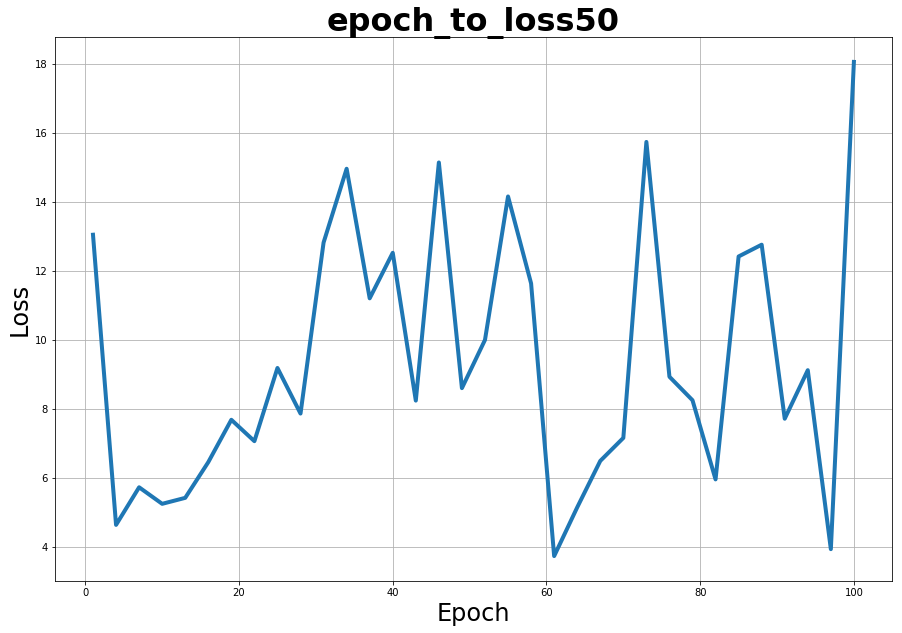

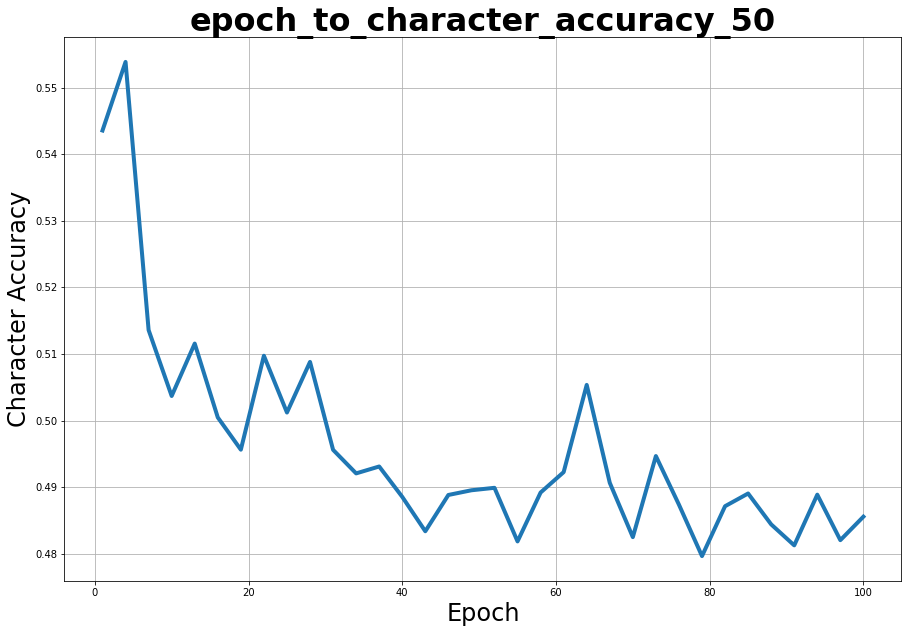

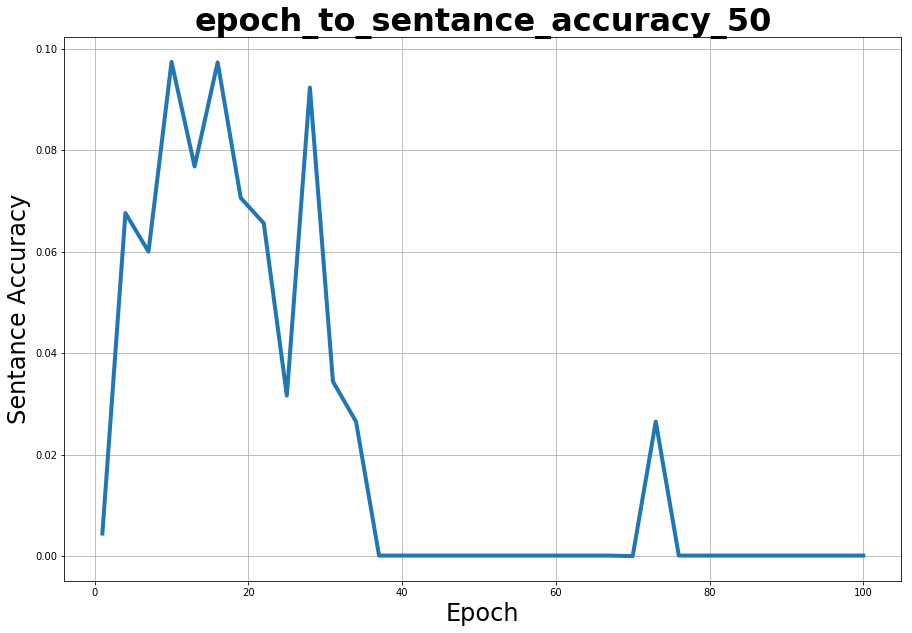

In [10]:
print("Luong Att")

seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                    bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention="Luong", bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="palindrome_dedup_K100_single_parameter/Luong_att")

seq2seq, ave_loss, character_accuracy_list, sentance_accuracy_list = t.train(seq2seq, train,
                                                                             num_epochs=100, dev_data=dev,
                                                                             optimizer=optimizer,
                                                                             teacher_forcing_ratio=0.5)

character_accuracy.append(character_accuracy_list)
sentance_accuracy.append(sentance_accuracy_list)

torch.save(seq2seq.state_dict(), 'log/pth/palindrome_dedup_K100_single_parameter_Luong_att_model_save.pth')

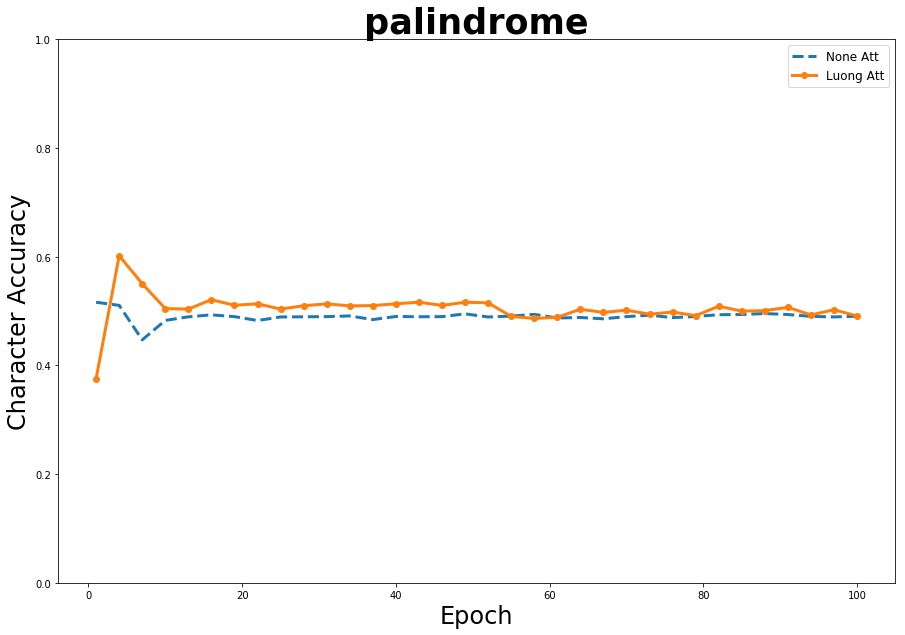

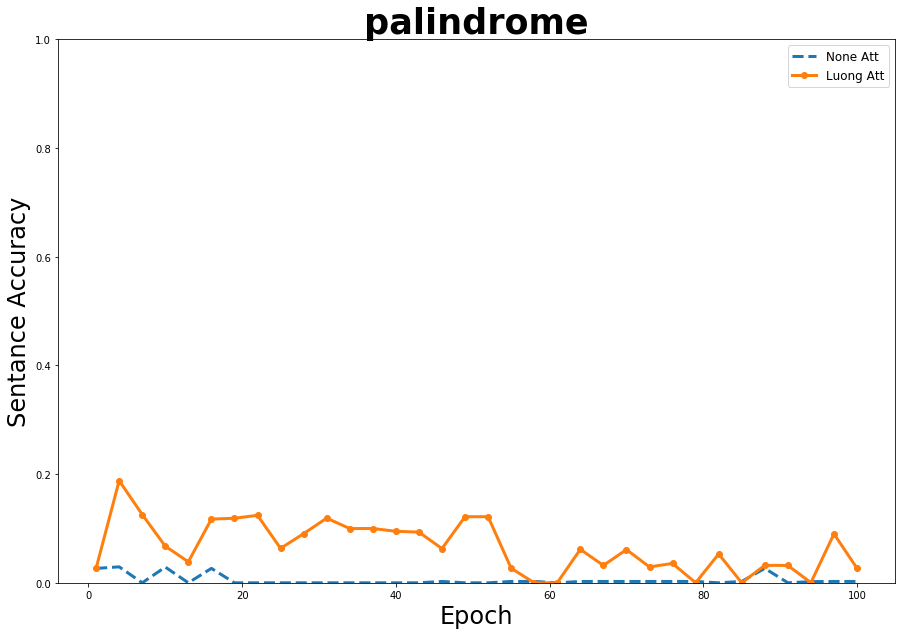

In [11]:
epochs = list(range(1, 101, 1))
plt.figure(figsize=(15,10))
plt.plot(epochs[::3], character_accuracy[0][::3], '--', LineWidth=3, label="None Att")
plt.plot(epochs[::3], character_accuracy[1][::3], '-o', LineWidth=3, label="Luong Att")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Character Accuracy', fontsize=24)
plt.ylim([0, 1])
plt.title('palindrome', fontsize=35, fontweight=560)
plt.savefig('log/plot/palindrome_dedup_K100_single_parameter/epoch_to_character_accuracy.png')

plt.figure(figsize=(15,10))
plt.plot(epochs[::3], sentance_accuracy[0][::3], '--', LineWidth=3, label="None Att")
plt.plot(epochs[::3], sentance_accuracy[1][::3], '-o', LineWidth=3, label="Luong Att")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Sentance Accuracy', fontsize=24)
plt.ylim([0, 1])
plt.title('palindrome', fontsize=35, fontweight=560)
plt.savefig('log/plot/palindrome_dedup_K100_single_parameter/epoch_to_sentance_accuracy.png')

In [12]:
print(character_accuracy[0])
print(character_accuracy[1])

[0.5160986976444266, 0.506677055549585, 0.5213586802536321, 0.510351430832511, 0.49163271553675353, 0.482788324068013, 0.4469055621232402, 0.4886357345005357, 0.48937012105165456, 0.48268980879896045, 0.47858188491462555, 0.48419847651428555, 0.48926387111271774, 0.48847167808141106, 0.4848624368606685, 0.4929447598018622, 0.4876908835109865, 0.48699598448506637, 0.4896343210913863, 0.4894694504964844, 0.48364972204038964, 0.4825147610068423, 0.48746372846912156, 0.47476747139800496, 0.48902043255530697, 0.4848286485659108, 0.4899872662908431, 0.48937052813954324, 0.4893851833035345, 0.4885868839538981, 0.4896400203218274, 0.4901366675459765, 0.4937670773369287, 0.49092153299528757, 0.4880711035989826, 0.4894319984107289, 0.48420580409628117, 0.488999671072986, 0.488507501815612, 0.4899363803047623, 0.4911010587541808, 0.4877564246610586, 0.48941327236785115, 0.4871054911271124, 0.49125860176708713, 0.4896371707066069, 0.4900234971129327, 0.48942670626817647, 0.4947685135429999, 0.4851

In [13]:
print(sentance_accuracy[0])
print(sentance_accuracy[1])

[0.02642855719211528, 0.0046638630339026965, 0.12379168078448569, 0.029358419867259282, 9.96551930321089e-05, 9.96551930321089e-05, 0.0, 0.0, 0.028919937017918004, 0.028919937017918004, 0.022940625435991468, 3.986207721284356e-05, 0.0, 5.979311581926534e-05, 0.0, 0.02652821238514739, 9.96551930321089e-05, 9.96551930321089e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002511310864409144, 0.0024913798258027224, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0024913798258027224, 0.0024913798258027224, 0.0024913798258027224, 0.0024913798258027224, 0.0024913798258027224, 0.0024913798258027224, 9.96551930321089e-05, 0.0, 0.0024913798258027224, 0.0024913798258027224, 0.0024913798258027224, 0.0024913798258027224, 0.0024913798258027224, 0.0024913798258027224, 0.0024913798258027224, 0.0024913798258027224, 0.0024913798258027224, 0.0024913798258027224, 0.0024913798258027224, 0.0024913798258027224, 0.002491379825802722